     label   centroid-0   centroid-1  perimeter  area  equivalent_diameter  \
350    351  5491.474317  7436.331328  306.83557  4322            74.181813   

     major_axis_length  minor_axis_length  eccentricity  feret_diameter_min  \
350          92.654144          70.502045       0.64885             82.9759   

     feret_diameter_max  feret_angle_min  feret_angle_max  file  
350          101.257099        -1.352127        -2.531676    22  
        area  file  label    centroid-0    centroid-1  eccentricity  \
53    156459    22     54   1926.414396   7259.128168      0.938016   
218   285464    22    219   4576.332921   7568.504197      0.742302   
285   308576    22    286   5609.907031   7041.618327      0.959304   
307   164817    22    308   5408.991142   7844.206253      0.866890   
449   290357    22    450   6848.827078   7693.523693      0.879778   
480   164298    22    481   6984.417930   6604.754842      0.899187   
750   223496    22    751   8628.717310   9249.141788  

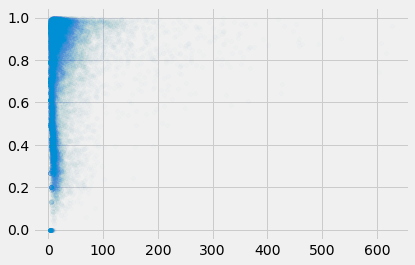

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import cv2
from sklearn import preprocessing, cluster, metrics

# the features are 
features = ['equivalent_diameter', 'eccentricity']
paths = pathlib.Path('./pyramid porosity/H porosity').glob('*.xlsx')
#paths = pathlib.Path('./Optical Micrographs').glob('*H.jpg')
paths_sorted = [x for x in paths]
paths_sorted.sort()

def toBW(img):
    (thresh, blackAndWhiteImage) = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
    return blackAndWhiteImage

pdframes = [pd.read_excel(path) for path in paths_sorted]
for index, frame in enumerate(pdframes):
    frame["file"] = index+1
all = pd.concat(pdframes)
# print(all[(all.label == 351) & (all.file == 22)])
# large = all[all['area'] > 150000 ]
# print(large[['area','file', 'label', 'centroid-0', 'centroid-1', 'eccentricity', 'perimeter']])
plt.scatter(all['equivalent_diameter'], all['eccentricity'], s=20, alpha=0.01)
plt.show()

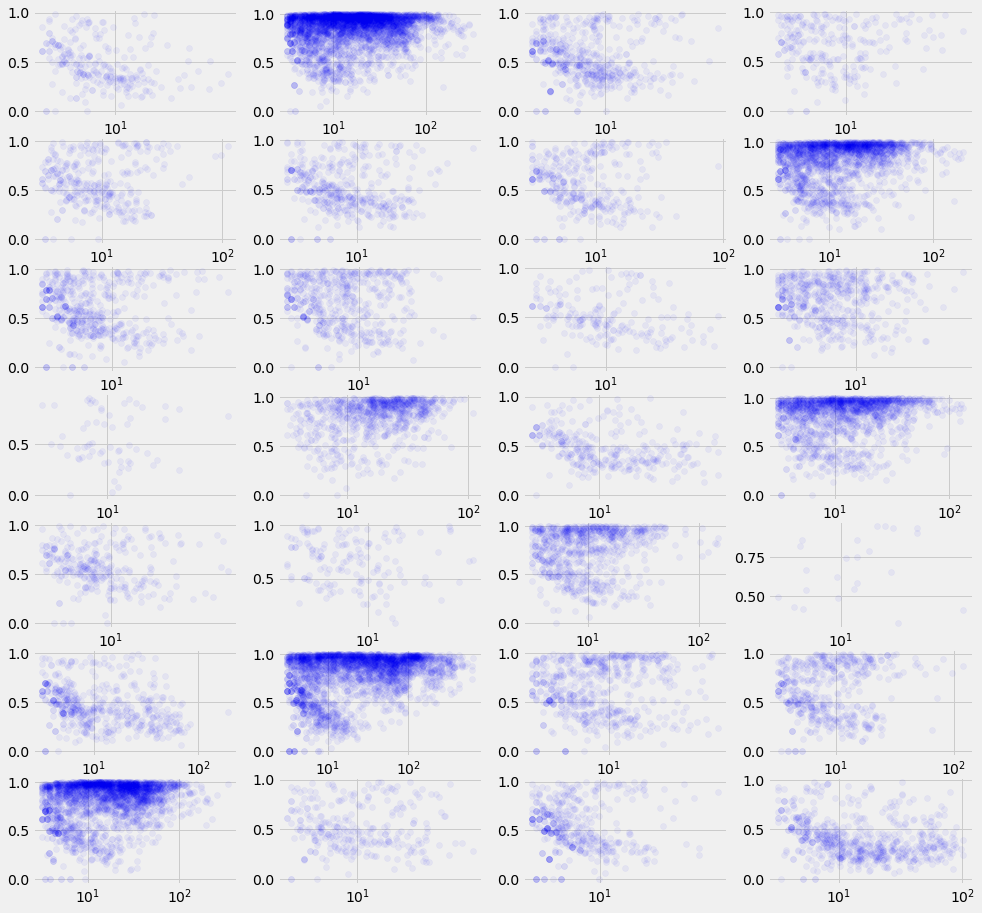

In [263]:
fig, axs = plt.subplots(7, 4, figsize=(15, 15))
for index, frame in enumerate(pdframes):
    axs[index//4, index%4].scatter(
        frame['equivalent_diameter'], frame['eccentricity'], c='blue', alpha=0.05)
    axs[index//4, index % 4].set_xscale("log")


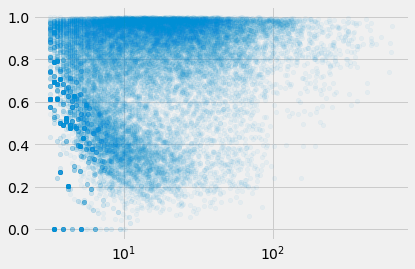

In [261]:
plt.scatter(all['equivalent_diameter'],
            all['eccentricity'], s=20, alpha=0.05)
plt.xscale('log')
plt.show()


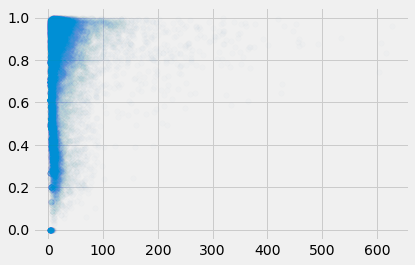

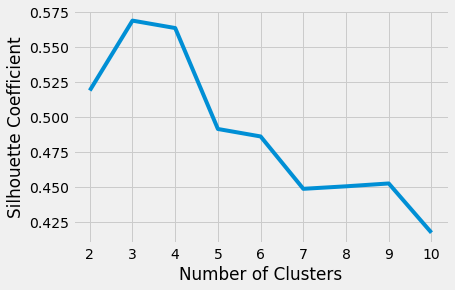

In [109]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

scaled = preprocessing.StandardScaler().fit_transform(all[features])
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled)
    score = metrics.silhouette_score(scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()


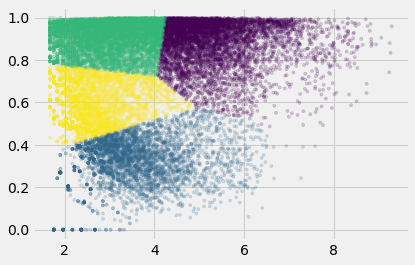

In [246]:
kmeans = cluster.KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(scaled)

plt.scatter(np.log2(all['equivalent_diameter']), all['eccentricity'], s=10, alpha=0.20, c=kmeans.labels_)
plt.show()

print()

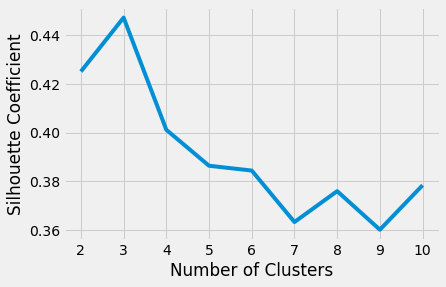

In [136]:
all["log"] = np.log(all['equivalent_diameter'])
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(
    all[["log", "eccentricity"]])
silhouette_coefficients = []
# plt.scatter(scaled[:, 0], scaled[:, 1], s=20, alpha=0.11)
# plt.show()
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled)
    score = metrics.silhouette_score(scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()


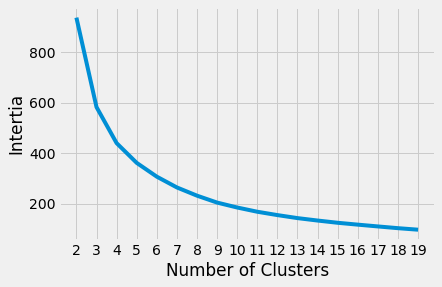

In [269]:
sse = []
for k in range(2, 20):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), sse)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
# plt.yscale('log')
plt.ylabel("Intertia")
plt.show()


Estimated number of clusters: 401
Estimated number of noise points: 3603
Estimated number of clustered points: 18399


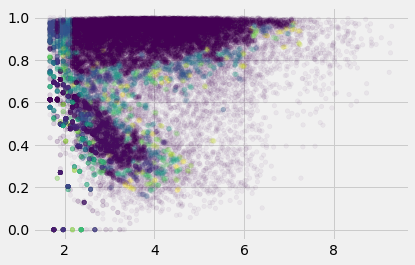

In [266]:
all["log"] = np.log(all['equivalent_diameter'])
scaler = preprocessing.StandardScaler()
scaled = preprocessing.MinMaxScaler().fit_transform(
    all[["log", "eccentricity"]])
# kmeans = cluster.KMeans(n_clusters=3, **kmeans_kwargs)
# kmeans.fit(scaled)

dbscan = cluster.DBSCAN(eps=0.006, min_samples=5).fit(scaled)
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_data_ = len(labels) - n_noise_
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Estimated number of clustered points: %d" % n_data_)

clusteredpoints = all[(labels != -1)]

plt.scatter(np.log2(clusteredpoints['equivalent_diameter']),
            clusteredpoints['eccentricity'], s=20, alpha=0.05, c=labels[(labels != -1)])
plt.scatter(np.log2(all['equivalent_diameter']),
            all['eccentricity'], s=20, alpha=0.05, c=labels)
plt.show()

print()


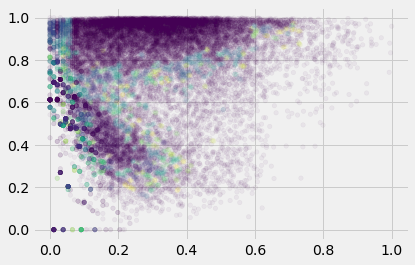

In [268]:
plt.scatter(scaled[:, 0], scaled[:, 1], s=20, alpha=0.05, c=labels)
plt.show()


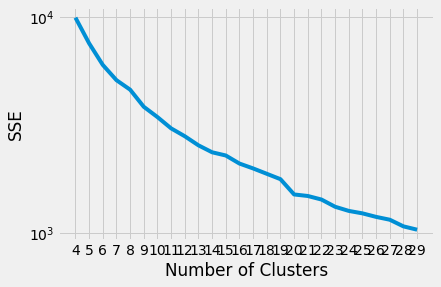

In [119]:
#scaled = preprocessing.StandardScaler().fit_transform(all[features])
sse = []
for k in range(4, 30):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(4, 30), sse)
plt.xticks(range(4, 30))
plt.xlabel("Number of Clusters")
plt.yscale('log')
plt.ylabel("SSE")
plt.show()


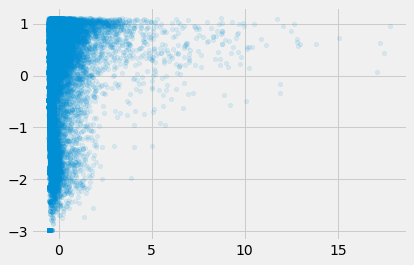

/Users/erik/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


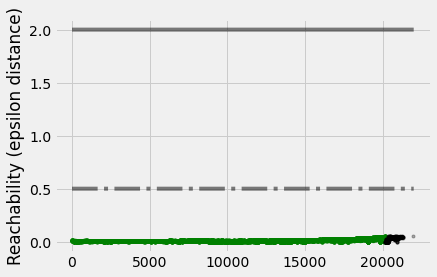

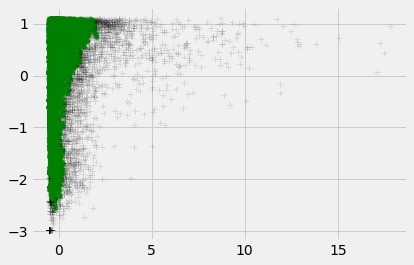

In [96]:
scaled = preprocessing.StandardScaler().fit_transform(all[features])
plt.scatter(scaled[:, 0], scaled[:, 1], s=20, alpha=0.11)
plt.show()
optics = cluster.OPTICS(min_cluster_size=0.3, max_eps=0.05)
optics.fit(scaled)
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]
space = np.arange(len(scaled))

#Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    plt.plot(Xk, Rk, color, alpha=0.3)
plt.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
plt.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
plt.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
plt.ylabel("Reachability (epsilon distance)")
plt.show()
for klass, color in zip(range(0, 5), colors):
    Xk = scaled[optics.labels_ == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(scaled[optics.labels_ == -1, 0], scaled[optics.labels_ == -1, 1], "k+", alpha=0.1)
plt.show()


[-0.08864838  0.23794447 -1.03769372 ... -0.34569886  0.42539694
 -1.17931436]


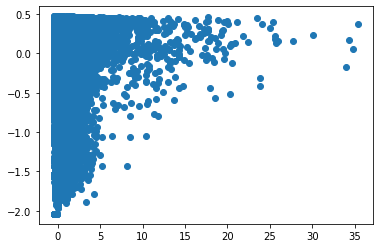

In [55]:
scaled = preprocessing.RobustScaler().fit_transform(all[features])
print(scaled[:, 1])
plt.scatter(scaled[:, 0], scaled[:, 1])
plt.show()


True

[[[  1  -1  -1  -1]
  [  2   0  -1  -1]
  [  3   1  -1  -1]
  ...
  [873 871  -1 265]
  [ -1 872  -1 265]
  [ -1 265  -1 109]]]
109540869.0
